**Author:** Raoul Malm  

**Description:** 

This notebook demonstrates the future price prediction for different stocks using recurrent neural networks in tensorflow. Recurrent neural networks with basic, LSTM or GRU cells are implemented. 

**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Analyze data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Model and validate data](#4-bullet)
5. [Predictions](#5-bullet)

**Reference:**  

[LSTM_Stock_prediction-20170507 by BenF](https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507/notebook)

# 1. Libraries and settings <a class="anchor" id="1-bullet"></a> 

In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 


# 2. Analyze data <a class="anchor" id="2-bullet"></a> 
- load stock prices from prices-split-adjusted.csv
- analyze data

In [2]:
# import all stock prices 
df = pd.read_csv("data/prices-split-adjusted.csv", index_col = 0)
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol)))


number of different stocks:  501
['NWL', 'COTY', 'AMT', 'KMI', 'PBI', 'CELG', 'MET', 'RTN', 'AJG', 'MLM', 'SYF', 'BWA', 'RHT', 'GE', 'DFS', 'CME', 'IDXX', 'FISV', 'MOS', 'EQIX', 'CSRA', 'ESS', 'MAT', 'GILD', 'FTV', 'HUM', 'BBT', 'TDC', 'MSI', 'NAVI', 'SNI', 'CHRW', 'MYL', 'TDG', 'URI', 'SEE', 'ALLE', 'AEP', 'DVA', 'KSS', 'FE', 'JWN', 'DHR', 'GM', 'VMC', 'UNH', 'MO', 'HBI', 'SPG', 'ATVI', 'KIM', 'ZBH', 'PYPL', 'PVH', 'QCOM', 'GPN', 'UAA', 'UNM', 'SYY', 'AIV', 'NUE', 'EFX', 'HSY', 'PEG', 'ADP', 'MDLZ', 'IR', 'EXR', 'PRGO', 'GOOGL', 'ABT', 'LLL', 'VNO', 'LKQ', 'BA', 'DHI', 'WLTW', 'PNW', 'EL', 'MPC', 'HOG', 'AFL', 'CHD', 'VLO', 'COST', 'STI', 'SIG', 'SYMC', 'AMG', 'LRCX', 'HPE', 'CBS', 'VFC', 'ZION', 'XRX', 'HPQ', 'AEE', 'CNP', 'TAP', 'MRK', 'AN', 'VAR', 'ARNC', 'ORCL', 'NVDA', 'KSU', 'HSIC', 'DOV', 'FSLR', 'TRIP', 'CF', 'USB', 'ES', 'BAX', 'CPB', 'MNST', 'LLY', 'SCHW', 'BAC', 'PFE', 'OXY', 'IRM', 'NBL', 'CVX', 'HRB', 'FMC', 'SLG', 'GS', 'GPC', 'ABBV', 'RF', 'TSS', 'JPM', 'AAP', 'EOG', '

In [3]:
df.tail()

symbol        open       close         low        high     volume
date                                                                        
2016-12-30    ZBH  103.309998  103.199997  102.849998  103.930000   973800.0
2016-12-30   ZION   43.070000   43.040001   42.689999   43.310001  1938100.0
2016-12-30    ZTS   53.639999   53.529999   53.270000   53.740002  1701200.0
2016-12-30    AIV   44.730000   45.450001   44.410000   45.590000  1380900.0
2016-12-30    FTV   54.200001   53.630001   53.389999   54.480000   705100.0

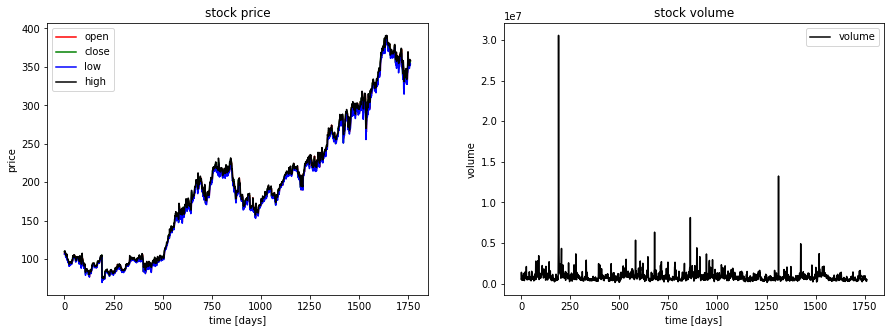

In [4]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 
- choose a specific stock
- drop feature: volume
- normalize stock data
- create train, validation and test data sets

In [5]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)


df_stock.columns.values =  ['open', 'close', 'low', 'high']
x_train.shape =  (1394, 19, 4)
y_train.shape =  (1394, 4)
x_valid.shape =  (174, 19, 4)
y_valid.shape =  (174, 4)
x_test.shape =  (174, 19, 4)
y_test.shape =  (174, 4)


/home/johannes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


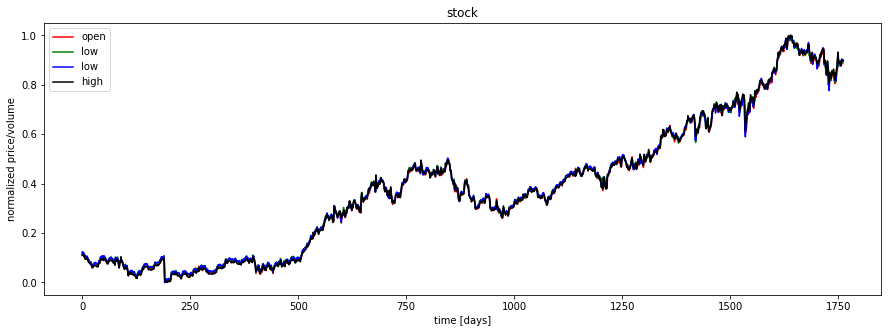

In [6]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

# 4. Model and validate data <a class="anchor" id="4-bullet"></a> 
- RNNs with basic, LSTM, GRU cells


In [7]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

/home/johannes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0.00 epochs: MSE train/valid = 0.268207/0.510007
4.99 epochs: MSE train/valid = 0.000170/0.001304
9.97 epochs: MSE train/valid = 0.000291/0.000464
14.96 epochs: MSE train/valid = 0.000122/0.000551
19.94 epochs: MSE train/valid = 0.000139/0.000370
24.93 epochs: MSE train/valid = 0.000137/0.000362
29.91 epochs: MSE train/valid = 0.000124/0.000428
34.90 epochs: MSE train/valid = 0.000111/0.000295
39.89 epochs: MSE train/valid = 0.000114/0.000320
44.87 epochs: MSE train/valid = 0.000088/0.000344
49.86 epochs: MSE train/valid = 0.000085/0.000364
54.84 epochs: MSE train/valid = 0.000084/0.000379
59.83 epochs: MSE train/valid = 0.000100/0.000380
64.81 epochs: MSE train/valid = 0.000079/0.000249
69.80 epochs: MSE train/valid = 0.000074/0.000277
74.78 epochs: MSE train/valid = 0.000075/0.000344
79.77 epochs: MSE train/valid = 0.000068/0.000264
84.76 epochs: MSE train/valid = 0.000080/0.000256
89.74 epochs: MSE train/valid = 0.000070/0.000203
94.73 epochs: MSE train/valid = 0.000062/0.000233
99.

In [8]:
y_train_pred

array([[0.08066279, 0.0804674 , 0.07967048, 0.07462323],
       [0.07720413, 0.07734826, 0.076949  , 0.07132906],
       [0.07717843, 0.0786367 , 0.07874021, 0.07315339],
       ...,
       [0.6608664 , 0.6475365 , 0.6517453 , 0.6580843 ],
       [0.6557642 , 0.64705545, 0.65104824, 0.6531906 ],
       [0.656209  , 0.6458757 , 0.6529413 , 0.6527255 ]], dtype=float32)

# 5. Predictions <a class="anchor" id="5-bullet"></a> 

In [9]:
y_train.shape

(1394, 4)

correct sign prediction for close - open price for train/valid/test: 0.46/0.36/0.39


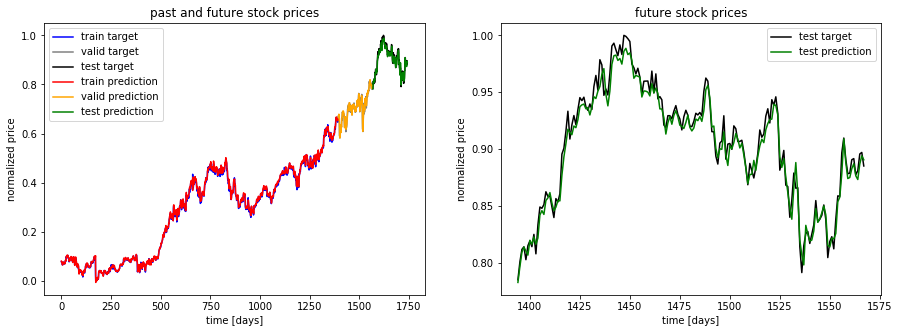

In [10]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))


In [25]:
print(y_test.size)
print(y_test_pred[173])

696
[0.8904714 0.8707441 0.8827877 0.8790411]


In [43]:
money_arr = np.zeros(172)
last_close = y_test[0][1]
last_close_pred = y_test_pred[0][1]
money = last_close
for i in range(173)[1:]:
    pred_close = y_test_pred[i][1]
    actual_close = y_test[i][1]
    if(pred_close > last_close_pred):
        money += (actual_close - last_close)
    elif(pred_close < last_close_pred):
        money -= (actual_close - last_close)
    last_close = y_test[i][1]
    last_close_pred = pred_close
    money_arr[i-1] = money
money_arr

array([0.81404524, 0.81940396, 0.80818521, 0.80157302, 0.7913258 ,
       0.78903825, 0.78295893, 0.77061218, 0.7515906 , 0.76437622,
       0.7645955 , 0.76324803, 0.74591859, 0.74015257, 0.72689691,
       0.70721718, 0.70806335, 0.70492963, 0.71104041, 0.70997496,
       0.67841843, 0.68781957, 0.70461624, 0.71549024, 0.7012005 ,
       0.68885366, 0.68387106, 0.67497132, 0.6605562 , 0.66575818,
       0.67199424, 0.67114818, 0.66202905, 0.66510004, 0.6651314 ,
       0.65638831, 0.67318498, 0.66415986, 0.6662594 , 0.68380823,
       0.6842469 , 0.70235977, 0.67265221, 0.68766273, 0.66926783,
       0.6974399 , 0.70279863, 0.70013495, 0.70245387, 0.70652766,
       0.72144417, 0.70022886, 0.69803522, 0.70289244, 0.70442803,
       0.69534027, 0.70737373, 0.70602626, 0.70480416, 0.70655903,
       0.68496769, 0.67149275, 0.66983189, 0.66635342, 0.65475863,
       0.63460877, 0.61173259, 0.59261691, 0.5753501 , 0.58512728,
       0.58180555, 0.56331665, 0.56707714, 0.55789528, 0.55977

No handles with labels found to put in legend.


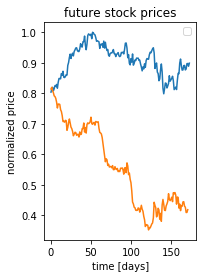

In [44]:
plt.subplot(1,2,2);

plt.plot(y_test[:,1])
plt.plot(money_arr)

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');
